In [1]:
import sys
sys.path.append('/Users/schoens/Documents/Projekte/Econ/Code/v3/')

import pandas as pd
import numpy as np

from pathlib import Path
import config.settings as cset

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats
from scipy.stats import kstest
from scipy.stats import ks_2samp

## Load Dataa

In [2]:
gmt_ds = pd.read_csv(cset.path_MESMER_char / f'gmt_dataset.csv', index_col = 0)

In [3]:
gdp_df   = pd.read_csv(cset.file_burke).loc[:, ['iso', 'scen', 'run', 'year', 'diff_SSP2', 'SSP2', 'SSP2_clim']]
gdp_df.loc[gdp_df.scen == 'Ref1p5', 'scen'] = 'Ref'
gdp_df['scen_run'] = gdp_df['scen'] + '_' + gdp_df['run'].astype(str)

## Analysis

### Step 1: Cluster GMT trajectories according to OS/ Non-OS 

In [4]:
# standardize gmt trajectories: 
gmt_std = StandardScaler().fit_transform(gmt_ds.values)

In [5]:
# fit kmeans cluster
kmeans = KMeans(init = 'k-means++', n_clusters = 15, n_init = 10, random_state = 42).fit(gmt_std.T)

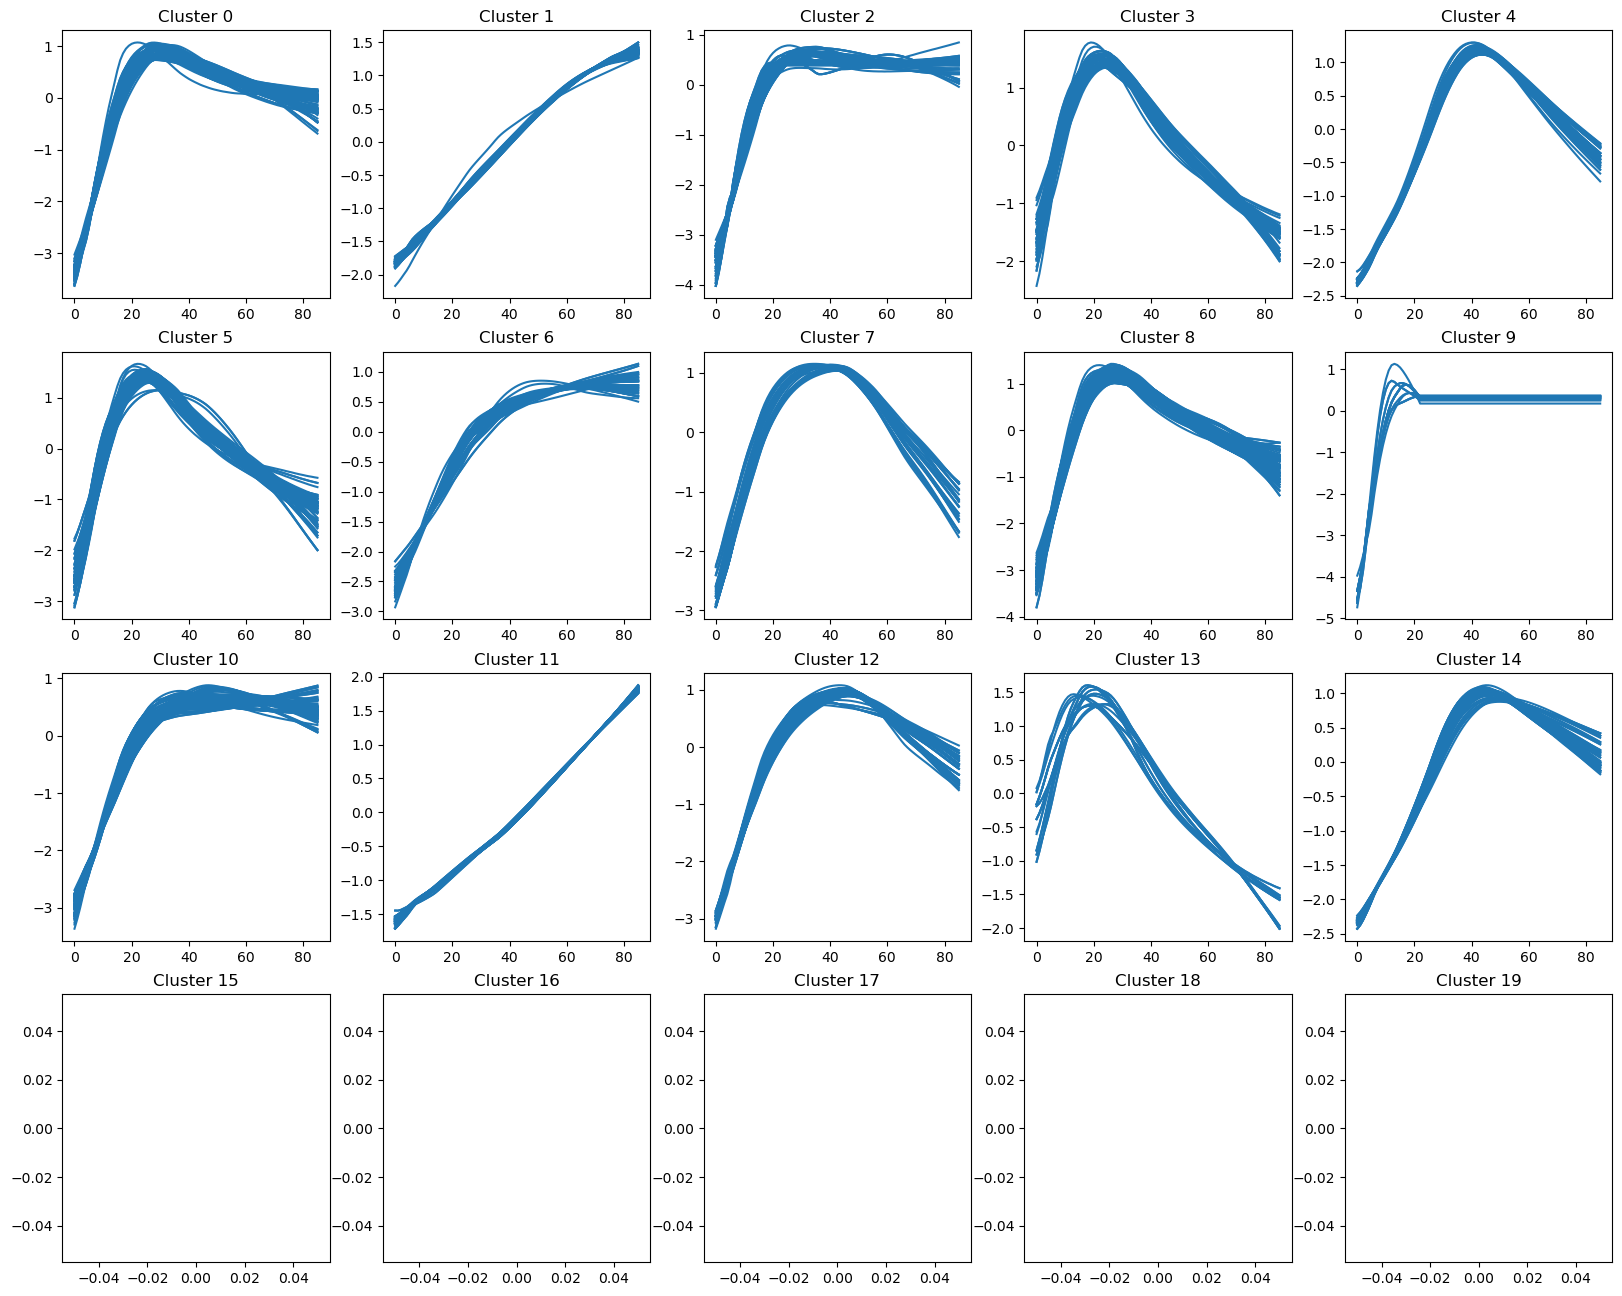

In [6]:
fig, ax = plt.subplots(4,5, figsize = (20, 16))
for i in range(20):
    ax[i//5, i%5].plot(gmt_std[:, kmeans.labels_ == i], color = 'C0')
    # ax[i//5, i%5].legend()
    ax[i//5, i%5].set_title(f'Cluster {i}')
plt.show()

In [7]:
OS_clusters = [0,2,3,4,5,7,11,13,14,15,16,18,19]
NONOS_clusters = [1,6,8,9,10,12,17]

os_idx = np.array([(label in OS_clusters) for label in kmeans.labels_])

gmt_os = gmt_ds.iloc[:, os_idx].values
gmt_nonos =  gmt_ds.iloc[:, ~os_idx].values

In [8]:
OS_clusters = [0,2,3,4,5,7,8,12,13,14,15]
NONOS_clusters = [1,6,9,10,11]

os_idx = np.array([(label in OS_clusters) for label in kmeans.labels_])

gmt_os = gmt_ds.iloc[:, os_idx].values
gmt_nonos =  gmt_ds.iloc[:, ~os_idx].values

In [9]:
np.shape(gmt_os), np.shape(gmt_nonos)

((86, 651), (86, 349))

### Step 2: Match trajectories with similar soc and eoc temperatures between clusters 

In [10]:
pairs  = []
err = 0.01
for i in range(gmt_os.shape[1]):
    for j in range(gmt_nonos.shape[1]):
        if (np.abs(gmt_os[0,i]-gmt_nonos[0,j]) <= err) & (np.abs(gmt_os[-1,i]-gmt_nonos[-1,j]) <= err):
            pairs.append([i,j])
pairs = np.array(pairs)

In [11]:
osunique = np.unique(pairs[:,0])
nonosunique = np.unique(pairs[:,1])
pair_dict_os = {}
pair_dict_nonos = {}
for i_o in osunique:
    pair_dict_os[i_o] = pairs[pairs[:,0] == i_o][:, 1]
for i_n in nonosunique:
    pair_dict_nonos[i_o] = pairs[pairs[:,1] == i_n][:, 0]

In [12]:
random_pair_realisations = []
for _ in range(500):
    pair_realisation = []
    shuffled_keys = list(pair_dict_os.keys())
    np.random.shuffle(shuffled_keys)
    pair_dict_os_tmp = {key: pair_dict_os[key] for key in shuffled_keys}
    while len(pair_dict_os_tmp.keys()) > 0:
        i_o = list(pair_dict_os_tmp.keys())[0]
        i_n = pair_dict_os_tmp[i_o][0]
        pair_realisation.append([i_o, i_n])
        new_keys = [key for key in pair_dict_os_tmp.keys() if not key == i_o]
        new_vals = [np.array(vals)[np.array(vals) != i_n] for vals in list(pair_dict_os_tmp.values())[1:]]
        idx_not_empty = np.array([idx for idx in range(len(new_vals)) if any(new_vals[idx] > 0)], dtype = int)
        pair_dict_os_tmp = dict(zip([new_keys[idx] for idx in idx_not_empty], 
                                    [new_vals[idx] for idx in idx_not_empty])) 
    pair_realisation = np.array(pair_realisation)  
    random_pair_realisations.append(pair_realisation)

### Step 3: Apply KS test to see if GDP distributions are significantly different 

In [13]:
def rename(newname):
    def decorator(f):
        f.__name__ = newname
        return f
    return decorator

def q_at(y):
    @rename(f'q{y:0.2f}')
    def q(x):
        return x.quantile(y)
    return q
    
f = {'diff_SSP2': [q_at(q) for q in np.arange(0.05,1,0.05)]}


In [14]:
pvals = []
for pair_realisation in tqdm(random_pair_realisations, total = len(random_pair_realisations)): 
    os_columns = gmt_ds.columns[os_idx][pair_realisation[:, 0]]
    nonos_columns = gmt_ds.columns[~os_idx][pair_realisation[:, 1]]
    gdp_2100_df = gdp_df[gdp_df.year == 2100].copy()

    os_gdp_distr = gdp_2100_df[gdp_2100_df.scen_run.isin(os_columns)].groupby('scen_run').agg(f).values
    nonos_gdp_distr = gdp_2100_df[gdp_2100_df.scen_run.isin(nonos_columns)].groupby('scen_run').agg(f).values
        
    pvals.append(ks_2samp(os_gdp_distr.flatten(), 
       nonos_gdp_distr.flatten(), 
       alternative= 'two-sided'
       ).pvalue)


  0%|          | 0/500 [00:00<?, ?it/s]

In [15]:
np.array(pvals).max()

0.9886438153028191

In [16]:
len(np.array(pvals)[np.array(pvals) > 0.01])

500

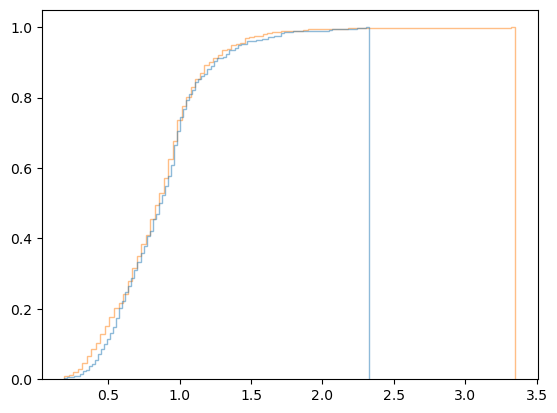

In [17]:
plt.figure()
plt.hist(os_gdp_distr.flatten(), bins = 100, alpha = 0.5, color = 'C1', label = 'OS', cumulative = True, histtype='step', density = True)
plt.hist(nonos_gdp_distr.flatten(), bins = 100, alpha = 0.5, color = 'C0', label = 'NON-OS', cumulative = True, histtype='step', density = True)
plt.show()

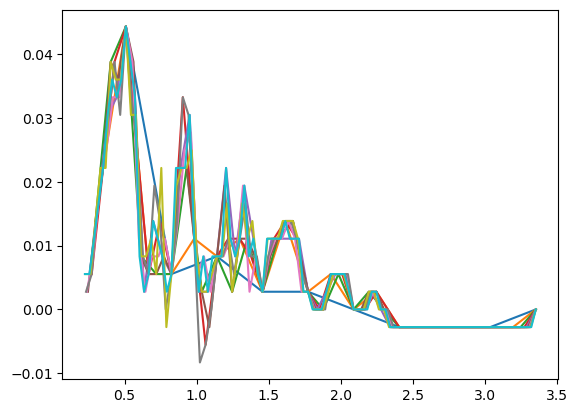

In [18]:
plt.figure()
for n_bins in range(10,110,10):
    # getting data of the histogram 
    count, bins_count = np.histogram(os_gdp_distr.flatten(), bins=n_bins) 
    # finding the PDF of the histogram using count values 
    os_pdf = count / sum(count) 
    # using numpy np.cumsum to calculate the CDF 
    # We can also find using the PDF values by looping and adding 
    os_cdf = np.cumsum(os_pdf) 
    # getting data of the histogram 
    count, bins_count = np.histogram(nonos_gdp_distr.flatten(), bins=bins_count) 
    # finding the PDF of the histogram using count values 
    nonos_pdf = count / sum(count) 
    # using numpy np.cumsum to calculate the CDF 
    # We can also find using the PDF values by looping and adding 
    nonos_cdf = np.cumsum(nonos_pdf) 
    d = os_cdf-nonos_cdf
    plt.plot(bins_count[1:], d)
plt.show()

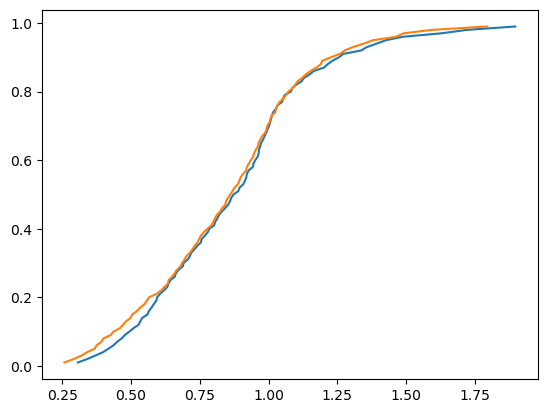

In [19]:
qs = np.arange(0.01,1,0.01)
plt.figure()
plt.plot(np.quantile(nonos_gdp_distr.flatten(), qs), qs, color = 'C0', label = 'NON-OS')
plt.plot(np.quantile(os_gdp_distr.flatten(), qs), qs, color = 'C1', label = 'OS')
plt.show()

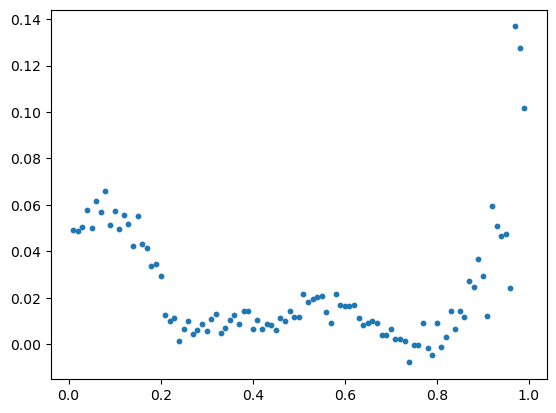

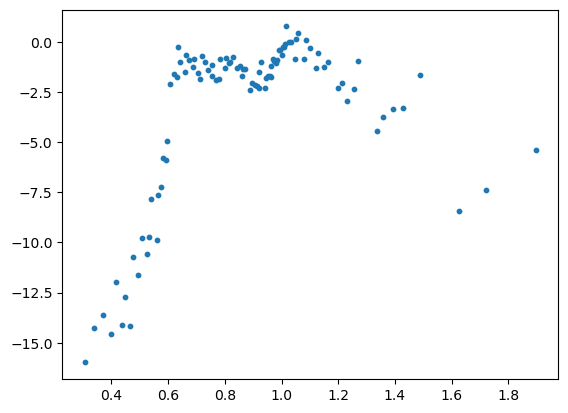

In [20]:
plt.figure()
plt.scatter(qs, np.quantile(nonos_gdp_distr.flatten(), qs)-np.quantile(os_gdp_distr.flatten(), qs), color = 'C0', label = 'OS', s = 10)
plt.show()

plt.figure()
plt.scatter(np.quantile(nonos_gdp_distr.flatten(), qs), ((np.quantile(os_gdp_distr.flatten(), qs)-np.quantile(nonos_gdp_distr.flatten(), qs))/np.quantile(nonos_gdp_distr.flatten(), qs))*100, color = 'C0', label = 'OS', s = 10)
plt.show()

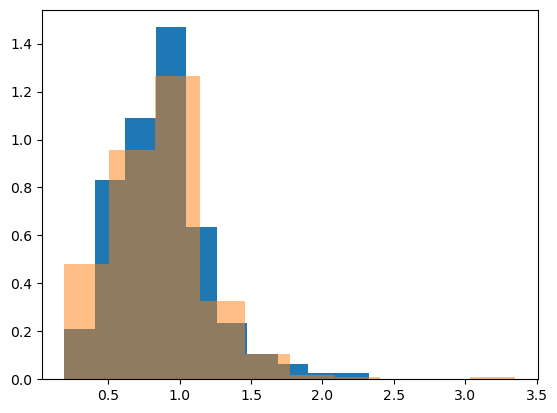

In [21]:
plt.figure()
plt.hist(nonos_gdp_distr.flatten(), density = True )
plt.hist(os_gdp_distr.flatten(), density = True, alpha = .5)
plt.show()

In [22]:
ks_2samp(os_gdp_distr.flatten(), 
       nonos_gdp_distr.flatten(), 
       alternative= 'two-sided'
       )

KstestResult(statistic=0.04986149584487535, pvalue=0.7613466189324183)

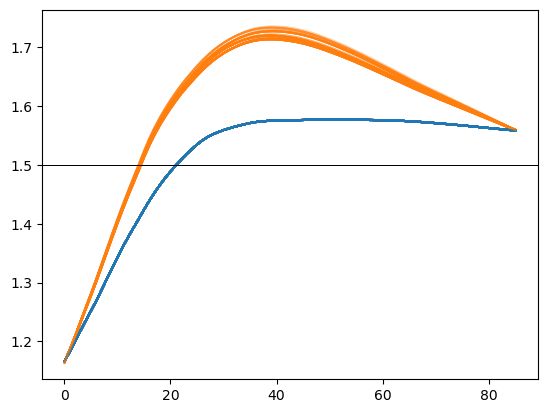

In [23]:
plt.figure()
for i in range(100):
    plt.plot(np.mean(gmt_nonos[:, np.unique(random_pair_realisations[i][:, 1])], axis = 1), color = 'C0', alpha = .2)
    plt.plot(np.mean(gmt_os[:, np.unique(random_pair_realisations[i][:, 0])], axis = 1), color = 'C1', alpha = .2)
    plt.axhline(1.5, color = 'black', lw = .5)
plt.show()

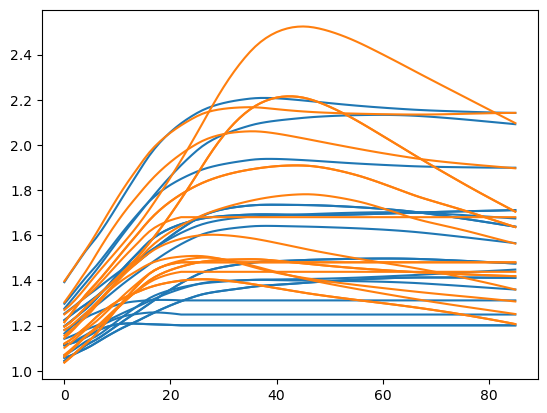

In [24]:
plt.figure()
plt.plot(gmt_nonos[:, np.unique(random_pair_realisations[20][:, 1])], color = 'C0')
plt.plot(gmt_os[:, np.unique(random_pair_realisations[20][:, 0])], color = 'C1')
plt.show()

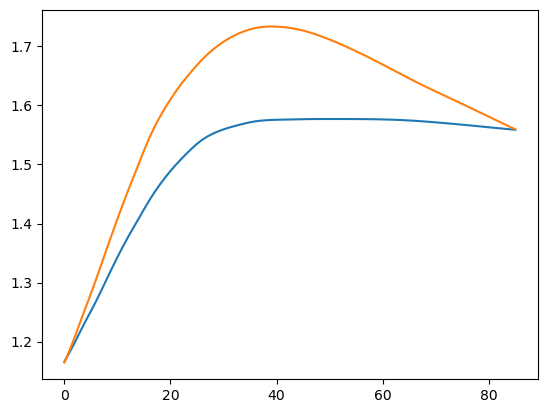

In [25]:
plt.figure()
plt.plot(np.mean(gmt_nonos[:, np.unique(random_pair_realisations[20][:, 1])], axis = 1), color = 'C0')
plt.plot(np.mean(gmt_os[:, np.unique(random_pair_realisations[20][:, 0])], axis = 1), color = 'C1')
plt.show()

### Step 4: Reference test - randomly split data into two groups and re-do analysis

In [26]:
import random
pvals = []
for _ in tqdm(range(100), total = 100): 
    test_gmt_ds = gmt_ds.loc[:, ~os_idx].copy()
    n_trajec   = test_gmt_ds.shape[1]
    test_gmt_ds = test_gmt_ds.iloc[:, np.array(random.sample(range(0, n_trajec), n_trajec))].copy()

    # randomly split data into two groups and compare the distributions
    random_ids = np.array(random.sample(range(0, n_trajec), n_trajec//2))
    group_ids  = np.array([(idx in random_ids) for idx in range(n_trajec)])

    gmt_1 = test_gmt_ds.iloc[:, group_ids].values
    gmt_2 = test_gmt_ds.iloc[:, ~group_ids].values

    ref_pairs  = []
    err = 0.01
    for i in range(gmt_1.shape[1]):
        for j in range(gmt_2.shape[1]):
            if len(ref_pairs) == 0: 
                if (np.abs(gmt_1[0,i]-gmt_2[0,j]) <= err) & (np.abs(gmt_1[-1,i]-gmt_2[-1,j]) <= err):
                    ref_pairs.append([i,j])  
            elif ((not i in np.array(ref_pairs)[:, 0]) & (not j in np.array(ref_pairs)[:, 1])):
                if (np.abs(gmt_1[0,i]-gmt_2[0,j]) <= err) & (np.abs(gmt_1[-1,i]-gmt_2[-1,j]) <= err):
                    ref_pairs.append([i,j])  
    ref_pairs = np.array(ref_pairs)
    
    group1_columns = test_gmt_ds.columns[group_ids][np.unique(ref_pairs[:, 0])]
    group2_columns = test_gmt_ds.columns[~group_ids][np.unique(ref_pairs[:, 1])]
    gdp_2100_df = gdp_df[gdp_df.year == 2100].copy()

    group1_gdp_distr = gdp_2100_df[gdp_2100_df.scen_run.isin(group1_columns)].groupby('scen_run').agg(f).values
    group2_gdp_distr = gdp_2100_df[gdp_2100_df.scen_run.isin(group2_columns)].groupby('scen_run').agg(f).values
    
    # gmt_1 = test_gmt_ds.iloc[:, group_ids].values
    # gmt_2 = test_gmt_ds.iloc[:, ~group_ids].values
    
    # group1_columns = test_gmt_ds.columns[group_ids][ref_pairs[:, 0]]
    # group2_columns = test_gmt_ds.columns[~group_ids][ref_pairs[:, 1]]
    # gdp_2100_df = gdp_df[gdp_df.year == 2100].copy()

    # group1_gdp_distr = []
    # group2_gdp_distr = []
    # for i in range(len(ref_pairs)): 
    #     group1_gdp_distr.append(gdp_2100_df[gdp_2100_df.scen_run == group1_columns[i]].diff_SSP2.values)
    #     group2_gdp_distr.append(gdp_2100_df[gdp_2100_df.scen_run == group2_columns[i]].diff_SSP2.values)

    # group1_gdp_distr = np.array(group1_gdp_distr)
    # group2_gdp_distr = np.array(group2_gdp_distr)
    
    pvals.append(ks_2samp(group1_gdp_distr.flatten(), 
       group2_gdp_distr.flatten(), 
       alternative= 'two-sided'
       ).pvalue)

  0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
len(group1_columns), len(group2_columns)

(64, 64)

In [28]:
np.array(pvals)[np.array(pvals) < 0.01].shape

(0,)

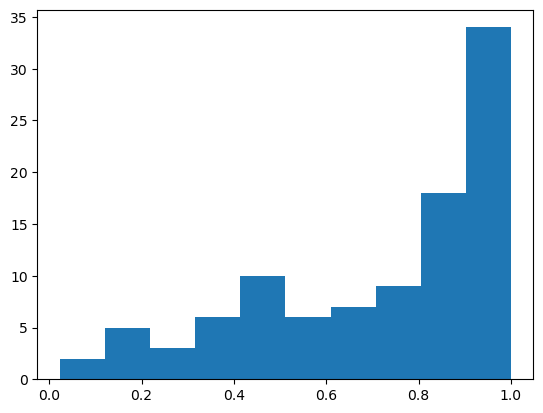

In [29]:
plt.figure()
plt.hist(pvals)
plt.show()

In [30]:
group1_gdp_distr = np.array(group1_gdp_distr)
group2_gdp_distr = np.array(group2_gdp_distr)

ks_2samp(np.quantile(group1_gdp_distr, 0.1, axis = 1), 
    np.quantile(group2_gdp_distr, 0.1, axis = 1), 
    alternative= 'two-sided'
    ).pvalue

0.9439990378651473

In [31]:
np.shape(np.quantile(os_gdp_distr, 0.1, axis = 0))

(19,)

In [32]:
group1_gdp_distr = np.array(group1_gdp_distr)
group2_gdp_distr = np.array(group2_gdp_distr)

ks_2samp(group1_gdp_distr.flatten(), 
    group2_gdp_distr.flatten(), 
    alternative= 'two-sided'
    ).pvalue

0.7289563245860545

In [33]:
np.shape(group1_gdp_distr)

(64, 19)

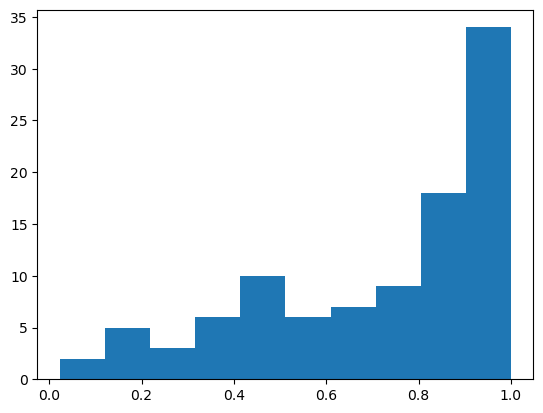

In [34]:
plt.figure()
plt.hist(pvals)
plt.show()

In [35]:
    test_gmt_ds = gmt_ds.loc[:,  nonos_columns].copy()
    n_trajec = test_gmt_ds.shape[1]
    test_gmt_ds = test_gmt_ds.iloc[:, np.array(random.sample(range(0, n_trajec), n_trajec))].copy()

    # randomly split data into two groups and compare the distributions
    random_ids = np.array(random.sample(range(0, 1000), n_trajec//1))
    group_ids  = np.array([(idx in random_ids) for idx in range(n_trajec)])

    gmt_1 = test_gmt_ds.iloc[:, group_ids].values
    gmt_2 = test_gmt_ds.iloc[:, ~group_ids].values

    ref_pairs  = []
    err = 0.01
    for i in range(gmt_1.shape[1]):
        for j in range(gmt_2.shape[1]):
            if not i == j: 
                if (np.abs(gmt_1[0,i]-gmt_2[0,j]) <= err) & (np.abs(gmt_1[-1,i]-gmt_2[-1,j]) <= err):
                    ref_pairs.append([i,j])
    ref_pairs = np.array(ref_pairs)
    
    group1_columns = test_gmt_ds.columns[group_ids][np.unique(ref_pairs[:, 0])]
    group2_columns = test_gmt_ds.columns[~group_ids][np.unique(ref_pairs[:, 1])]
    gdp_2100_df = gdp_df[gdp_df.year == 2100].copy()

    group1_gdp_distr = gdp_2100_df[gdp_2100_df.scen_run.isin(group1_columns)].groupby('scen_run').agg(f).values
    group2_gdp_distr = gdp_2100_df[gdp_2100_df.scen_run.isin(group2_columns)].groupby('scen_run').agg(f).values
    # for i in range(len(ref_pairs)): 
    #     group1_gdp_distr.append(gdp_2100_df[gdp_2100_df.scen_run == group1_columns[i]].diff_SSP2.values)
    #     group2_gdp_distr.append(gdp_2100_df[gdp_2100_df.scen_run == group2_columns[i]].diff_SSP2.values)

    group1_gdp_distr = np.array(group1_gdp_distr)
    group2_gdp_distr = np.array(group2_gdp_distr)
    
    ks_2samp(group1_gdp_distr.flatten(), 
       group2_gdp_distr.flatten(), 
       alternative= 'two-sided'
       )

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [288]:
np.shape(group2_gdp_distr)[0]/157

94.0

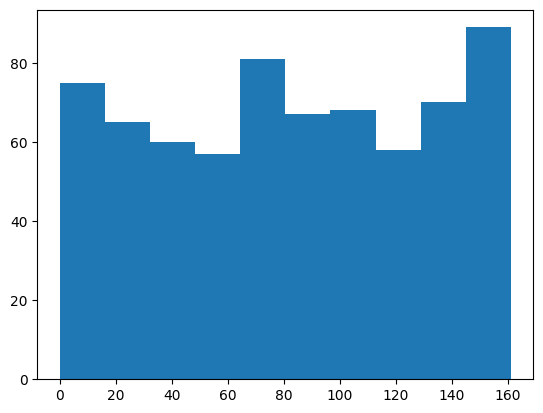

In [289]:
plt.figure()
plt.hist(ref_pairs[:,0])
plt.show()

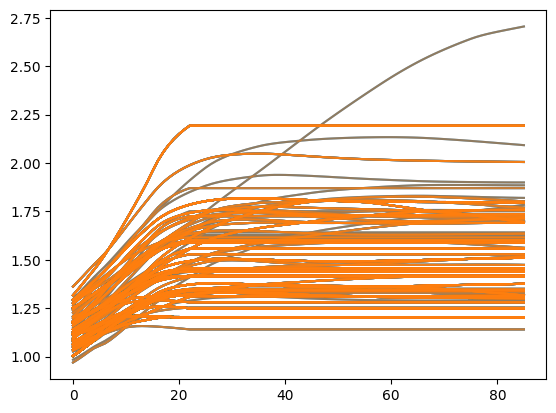

In [278]:
plt.figure()
plt.plot(gmt_1[:, ref_pairs[:, 0]], color = 'C0')
plt.plot(gmt_2[:, ref_pairs[:, 1]], color = 'C1', alpha = .5)
plt.show()

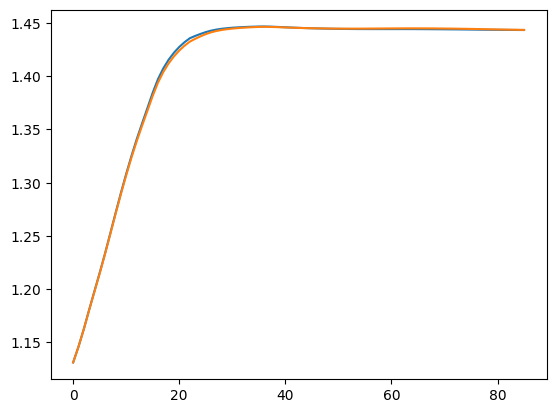

In [223]:
plt.figure()
plt.plot(np.mean(gmt_1[:, ref_pairs[:, 0]], axis = 1), color = 'C0')
plt.plot(np.mean(gmt_2[:, ref_pairs[:, 1]], axis = 1), color = 'C1')
plt.show()

In [176]:
group1_columns = test_gmt_ds.columns[group_ids][ref_pairs[:, 0]]
group2_columns = test_gmt_ds.columns[~group_ids][ref_pairs[:, 1]]
gdp_2100_df = gdp_df[gdp_df.year == 2100].copy()

group1_gdp_distr = []
group2_gdp_distr = []
for i in range(len(pairs)): 
    group1_gdp_distr.append(gdp_2100_df[gdp_2100_df.scen_run == group1_columns[i]].diff_SSP2.values)
    group2_gdp_distr.append(gdp_2100_df[gdp_2100_df.scen_run == group2_columns[i]].diff_SSP2.values)

group1_gdp_distr = np.array(group1_gdp_distr)
group2_gdp_distr = np.array(group2_gdp_distr)

In [180]:
ks_2samp(group1_gdp_distr.flatten(), 
       group2_gdp_distr.flatten(), 
       alternative= 'two-sided'
       ).pvalue

0.07487750228543721

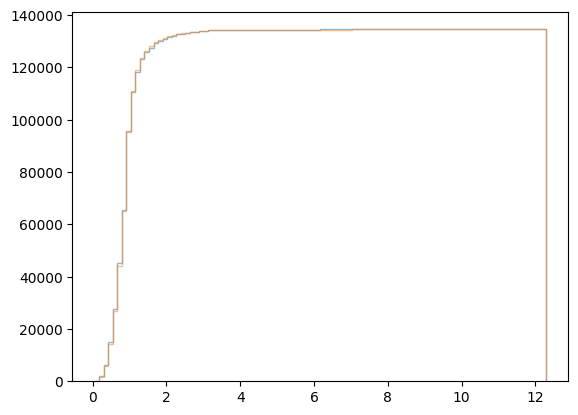

In [264]:
plt.figure()
plt.hist(group1_gdp_distr.flatten(), bins = 100, alpha = 0.5, color = 'C0', label = 'Group 1', cumulative = True, histtype='step')
plt.hist(group2_gdp_distr.flatten(), bins = 100, alpha = 0.5, color = 'C1', label = 'Group 2', cumulative = True, histtype='step')
plt.show()